# About
Roughwork exploration GameStop Stock return data:
1. Power Law Tail Exploration
2. Gaussian comparison
3. Tail event data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
data_source = 'https://query1.finance.yahoo.com/v7/finance/download/GME?period1=1013558400&period2=1611878400&interval=1d&events=history&includeAdjustedClose=true'

In [3]:
# Load Data
price_data = pd.read_csv(data_source)
price_data = price_data.set_index('Date')
price_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,9.625,10.060,9.525,10.050,6.766666,19054000
2002-02-14,10.175,10.195,9.925,10.000,6.733003,2755400
2002-02-15,10.000,10.025,9.850,9.950,6.699336,2097400
2002-02-19,9.900,9.900,9.375,9.550,6.430017,1852600
2002-02-20,9.600,9.875,9.525,9.875,6.648838,1723200


In [4]:
# Calculate Returns
close_price = price_data.Close
previous_close_price = price_data.Close

returns = close_price / previous_close_price.shift(1) - 1
returns.name = 'daily_return'
returns

Date
2002-02-13         NaN
2002-02-14   -0.004975
2002-02-15   -0.005000
2002-02-19   -0.040201
2002-02-20    0.034031
                ...   
2021-01-22    0.510806
2021-01-25    0.181203
2021-01-26    0.927074
2021-01-27    1.348358
2021-01-28   -0.442894
Name: daily_return, Length: 4773, dtype: float64

In [5]:
# Remove nan value
print(f'There are {returns.isna().sum()} NaN values in the data.')
returns = returns.dropna()

There are 1 NaN values in the data.


# Check right tail for Power Law

In [6]:
# Helper Function
def get_exceedance_probability(price_sr):
    
    price_sr = price_sr.copy()

    # Get Dataset Size
    price_count = len(price_sr)
    total_gap_count = price_count + 1 # i.e. gaps between prices where probability is bounded by 0 and 1.

    # Sort from low to high
    price_sr = price_sr.sort_values() # Sort
    price_df = price_sr.reset_index() # Keep old index
    price_df = price_df.rename(columns={'index':'old_index'})
    
    # Create index starting at one (as opposed to zero)
    ## `left_gap_count` counts the number of values which are less than or equal to a given price
    price_df['left_gap_count'] = 1
    price_df['left_gap_count'] = price_df.left_gap_count.cumsum()
    price_df['right_gap_count'] = total_gap_count - price_df.left_gap_count

    # Get Survival Probability
    survival_probability_fn = f'right_gap_count/{total_gap_count}'
    price_df['survival_probability'] = price_df.eval(survival_probability_fn)
    # Get Cumulative Probability (CDF)
    cumulative_probability_fn = f'left_gap_count/{total_gap_count}'
    price_df['cumulative_probability'] = price_df.eval(cumulative_probability_fn)
    
    return price_df

In [7]:
survival_df = get_exceedance_probability(returns)

Power laws are straight on loglog plots, therefore we'll plot the empirical right tail as such to see if it is also straight in part.

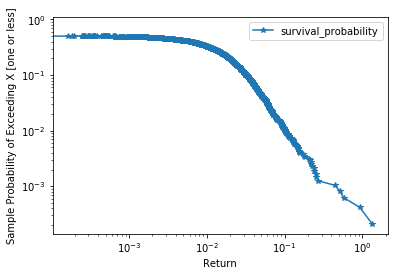

In [8]:
ax = survival_df.loc[survival_df.survival_probability<0.75].plot(x='daily_return', y='survival_probability', loglog=True, marker='*')
ax.set_xlabel('Return')
ax.set_ylabel('Sample Probability of Exceeding X [one or less]');

Let's think about a 1 in 200 event. This means an event with 0.5% probability.

In [9]:
1/200

0.005

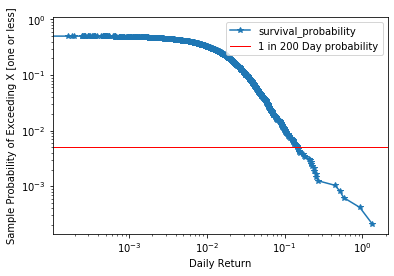

In [10]:
# Plot and Emphasise 1/200 probability
ax = survival_df.loc[survival_df.survival_probability<0.75].plot(x='daily_return', y='survival_probability', loglog=True, marker='*')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Sample Probability of Exceeding X [one or less]');
ax.axhline(y=1/200, lw=1, color='red', label='1 in 200 Day probability')
ax.legend();

### Fit a Normal Distribution

In [11]:
def fit_gaussian_pdf(mean, std):
    
    x = np.linspace(mean-4*std, mean+4*std, 100)                   # 100 equally spaced x locations
    y = norm.pdf(x, loc=mean, scale=std) # 100 corresponding probability densities

    return x,y

In [12]:
# Get Mean and Standard Deviation from Dataset
norm_params = ['50%', 'mean', 'std']
norm_params = returns.describe().loc[norm_params]

mean=norm_params.loc['mean']
std = norm_params.loc['std']

norm_params.to_frame()

,daily_return
50%,0.000379
mean,0.001414
std,0.042956


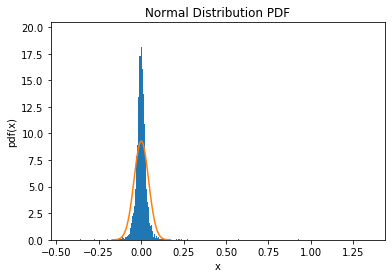

In [13]:
x, y = fit_gaussian_pdf(mean,std)

# Plot Histogram
normalization_kwargs = {'stacked':True, 'density':True}
ax = returns.plot(kind='hist', **normalization_kwargs, bins=500)

ax.plot(x, y)
ax.set(xlabel='x', ylabel='pdf(x)',
       title='Normal Distribution PDF')
#ax.grid()
plt.show()

### Explore tail data
* Examine the tail for power law behaviour

In [14]:
# Make a 12 bin histogram
bins=12

In [15]:
# Get Probabilities
freq, bin_edges = np.histogram(returns, bins=bins)
prob, bin_edges = np.histogram(returns, bins=bins, density=True)

width = (bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:]) / 2

In [16]:
dozen_hist = pd.DataFrame([freq,center], index=['freq', 'bin_center']).T
dozen_hist.bin_center = dozen_hist.bin_center.round(2)
dozen_hist.index.name = 'bin_number'

In [17]:
dozen_hist.T

bin_number,0,1,2,3,4,5,6,7,8,9,10,11
freq,3.00,10.00,2765.00,1975.00,14.00,1.00,2.00,0.00,0.00,1.00,0.00,1.00
bin_center,-0.37,-0.22,-0.07,0.08,0.23,0.38,0.53,0.68,0.83,0.98,1.12,1.27
